In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import random as rd
import itertools as itt
import matplotlib.dates as mdates
import matplotlib as mpl
import seaborn as sns
import scipy as sp
import scipy.integrate as integrate
from scipy.optimize import curve_fit
import scipy.stats as stats

#from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing


In [4]:

wrest_results =pd.read_csv('cleaned_wrestling_results.csv',sep = ',')
wrest_results['date']=pd.to_datetime(wrest_results['date'],format = '%Y-%m-%d',errors = 'coerce')

match = (wrest_results['by'] == 'MFOR') | (wrest_results['by'] == 'DQ') | (wrest_results['by'] == 'INJ') | (wrest_results['by'] == None) | (wrest_results['by'] == 'FOR') 
wrest_results = wrest_results.drop(wrest_results[match].index, axis = 0).reset_index(drop = True)


In [5]:
train_data_18 = wrest_results[ (wrest_results['event'] != 'NCAA Championships') & (wrest_results['season'] == 2018) ].reset_index(drop = True)
test_data_18  = wrest_results[ (wrest_results['event'] == 'NCAA Championships') & (wrest_results['season'] == 2018) ].reset_index(drop = True)

training_data_1819 = wrest_results[ (wrest_results['event'] != 'NCAA Championships') | (wrest_results['season'] != 2019) ].reset_index(drop = True)
test_data_19 = wrest_results[(wrest_results['event'] == 'NCAA Championships') & (wrest_results['season'] == 2019) ].reset_index(drop = True)

train_data_19 = wrest_results[ (wrest_results['event'] != 'NCAA Championships') & (wrest_results['season'] == 2019) ].reset_index(drop = True)

sea_data_157_19 = wrest_results[ (wrest_results['season'] == 2019) & (wrest_results['weight'] == 157) ].reset_index(drop = True)
train_data_157_19 = wrest_results[ (wrest_results['event'] != 'NCAA Championships') & (wrest_results['season'] == 2019) & (wrest_results['weight'] == 157) ].reset_index(drop = True)
test_data_157_19 = wrest_results[ (wrest_results['event'] == 'NCAA Championships') & (wrest_results['season'] == 2019) & (wrest_results['weight'] == 157) ].reset_index(drop = True)

sea_data_165_19 = wrest_results[ (wrest_results['season'] == 2019) & (wrest_results['weight'] == 165) ].reset_index(drop = True)
train_data_165_19 = wrest_results[ (wrest_results['event'] != 'NCAA Championships') & (wrest_results['season'] == 2019) & (wrest_results['weight'] == 165) ].reset_index(drop = True)
test_data_165_19 = wrest_results[ (wrest_results['event'] == 'NCAA Championships') & (wrest_results['season'] == 2019) & (wrest_results['weight'] == 165) ].reset_index(drop = True)

train_data_133_18 = wrest_results[ (wrest_results['event'] != 'NCAA Championships') & (wrest_results['season'] == 2018) & (wrest_results['weight'] == 133) ].reset_index(drop = True)
test_data_133_18  = wrest_results[ (wrest_results['event'] == 'NCAA Championships') & (wrest_results['season'] == 2018) & (wrest_results['weight'] == 133) ].reset_index(drop = True)


In [6]:
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',100)

hist_data = pd.concat([train_data_157_19,test_data_157_19]).reset_index(drop = True)
training_data = train_data_157_19.copy()
testing_data = test_data_157_19.copy()


In [7]:
def model_score(test_data, model, metric):
    correct, incorrect,uncalled = 0,0,0
    
    for i in test_data.index:
        if model.loc[test_data.loc[i,'wrest_name'],metric] > model.loc[test_data.loc[i,'opp_name'],metric]:
            correct = correct + 1
        elif model.loc[test_data.loc[i,'wrest_name'],metric] < model.loc[test_data.loc[i,'opp_name'],metric]:
            incorrect = incorrect + 1
        else: 
            uncalled = uncalled + 1

    score = round(correct / (incorrect + correct)*100,2)
    print('score:', score,'correct:',correct,'incorrect',incorrect,'uncalled:',uncalled)
    
def model_eval(test_data, model, metric,info):
    correct, incorrect,uncalled = 0,0,0
    
    for i in test_data.index:
        if model.loc[test_data.loc[i,'wrest_name'],metric] > model.loc[test_data.loc[i,'opp_name'],metric]:
            correct = correct + 1
            test_data.loc[i,'guess'] = 1
        elif model.loc[test_data.loc[i,'wrest_name'],metric] < model.loc[test_data.loc[i,'opp_name'],metric]:
            incorrect = incorrect + 1
            test_data.loc[i,'guess'] = -1
        else: 
            uncalled = uncalled + 1
            test_data.loc[i,'guess'] = 0
    score = round(correct / (incorrect + correct)*100,2)
    print('score:', score,'correct:',correct,'incorrect',incorrect,'uncalled:',uncalled)
    
    if info == 'correct':
        return test_data[test_data['guess']==1]
    elif info == 'incorrect':
        return test_data[test_data['guess']==-1]
    else:
        return test_data[test_data['guess']==0]
    
def wrest_lookup(wrest_name,model,columns):
    match = (model['wrest_name'] == wrest_name) | (model['opp_name'] == wrest_name)
    return model.loc[match] if columns=='all' else model.loc[match,columns]

def wp_logistic(x):
    return x*0 #1- (0.95 / (1 + np.exp(-0.35*x + -0.11))) # 

def logistic(a,b,s):
    return 1/ (1 + np.exp(a*s + b))

def inv_logistic(a,b,p): # input the alpha beta and percentage, get the skill
    return (1/a)*(np.log((1/p)-1)-b) 

def beta_logistic(a,p,s):
    return np.log((1/p)-1) - a*s

def error_func(p):
    try: 
        return ( ( ( abs((1/30)*np.log( (2/(p+1) -1) )) + abs(p) )**2 ) / len(p) ).sum()
    except:
        try:
            return  ( ( abs((1/30)*np.log( (2/(p+1) -1) )) + abs(p) )**2 )
        except:
            return 0

def foo_error_func(p):
    try: 
        return (  (p)**2 / len(p) ).sum()
    except:
        try:
            return (  (p)**2 )
        except:
            return 0

In [8]:

training_data['pt_diff'] = training_data['winner_pts'] - training_data['loser_pts']
pd.set_option('display.max_columns',None)

In [9]:
training_data['score_diff'] = training_data['winner_pts'] - training_data['loser_pts']
match_fall = (training_data['by'] == 'FALL')
training_data.loc[match_fall,'score_diff'] = 5.2
match_ot = (training_data['by'] == 'SV-1') | (training_data['by'] == 'SV-2') | (training_data['by'] == 'TB-1') |(training_data['by'] == 'TB-2')
training_data.loc[match_ot,'score_diff'] = 0.5

In [10]:
wrest_names = pd.concat([training_data['wrest_name'],training_data['opp_name']]).unique()

opp_func_w = lambda x: pd.Series( training_data.loc[(training_data['wrest_name'] == x),'opp_name'] )
opp_func_l = lambda x: pd.Series( training_data.loc[(training_data['opp_name'] == x),'wrest_name'] )

opop_func_w = lambda x: training_data.loc[training_data['wrest_name'].str.contains("|".join(opp_func_w(x).to_numpy())),'opp_name'] if len(opp_func_w(x)) > 0 else pd.Series([],dtype = float).rename('opp_name')
opop_func_l = lambda x: training_data.loc[training_data['opp_name'].str.contains("|".join(opp_func_l(x).to_numpy())),'wrest_name'] if len(opp_func_l(x)) > 0 else pd.Series([],dtype = float).rename('wrest_name')

opp_func = lambda x: pd.Series(pd.concat([training_data.loc[(training_data['opp_name'] == x),'wrest_name'],training_data.loc[(training_data['wrest_name'] == x),'opp_name']],axis = 0)).rename('opp_name')

ptd_func_w = lambda x: pd.Series( training_data.loc[(training_data['wrest_name'] == x),'score_diff'] )
ptd_func_l = lambda x: pd.Series( training_data.loc[(training_data['opp_name'] == x),'score_diff'] )

by_func_w =  lambda x: pd.Series(training_data.loc[(training_data['wrest_name'] == x),'by']).rename('by')
by_func_l =  lambda x: pd.Series(training_data.loc[(training_data['opp_name'] == x),'by']).rename('by')
by_func =  lambda x: pd.Series(pd.concat([training_data.loc[(training_data['opp_name'] == x),'by'],training_data.loc[(training_data['wrest_name'] == x),'by']],axis = 0)).rename('by')

wrest_opp_w = pd.Series(wrest_names).apply(opp_func_w).set_index(wrest_names)
wrest_opp_l = pd.Series(wrest_names).apply(opp_func_l).set_index(wrest_names)
wrest_opp = pd.Series(wrest_names).apply(opp_func).set_index(wrest_names)

win_func = lambda x:   (training_data['wrest_name'] == x).sum() if (training_data['wrest_name'] == x).sum() > 0 else 0
loss_func =  lambda x: (training_data['opp_name'] == x).sum() if (training_data['opp_name'] == x).sum() > 0 else 0

tw_func = lambda x: wrest_opp_w.loc[x].dropna().apply(win_func).sum()
tl_func = lambda x: wrest_opp_l.loc[x].dropna().apply(loss_func).sum() 
t_func = lambda x: pd.Series(wrest_opp_w.loc[x].dropna().apply(win_func).sum() + win_func(x) - wrest_opp_l.loc[x].dropna().apply(loss_func).sum() - loss_func(x))


In [11]:

st_alpha = 0.05
st_skill = pd.Series(wrest_names).apply(t_func).set_index(wrest_names)[0]
st_beta = beta_logistic(st_alpha, 0.5,st_skill)

wrest_names = pd.concat([hist_data['wrest_name'],hist_data['opp_name']]).unique()
info = ['alpha','beta','skill']
wrest_info = pd.DataFrame(0, index = wrest_names, columns = info)

wrest_info['alpha'] = st_alpha
wrest_info['beta'] = st_beta
wrest_info['skill'] = st_skill

wrest_info.sort_values(by = 'skill',ascending = False)

,alpha,beta,skill
Ryan Deakin,0.05,-18.80,376
Tyler Berger,0.05,-17.35,347
Zach Hartman,0.05,-17.25,345
Jason Nolf,0.05,-16.85,337
Larry Early,0.05,-12.75,255
...,...,...,...
Ryan Resnick,0.05,6.10,-122
Nico Odor,0.05,6.45,-129
Christian LaBrie,0.05,7.65,-153
Nate Newberry,0.05,8.15,-163


In [12]:
def bfit_func(x):
    df_w = pd.concat([opp_func_w(x), by_func_w(x),1-wp_logistic(ptd_func_w(x))], axis = 1).rename(columns = {'score_diff':'wp'}).dropna() 
    df_w['skill'] = wrest_info.loc[opp_func_w(x),'skill'].to_numpy()
    
    df_l = pd.concat([opp_func_l(x), by_func_l(x), wp_logistic(ptd_func_l(x))], axis = 1).rename(columns = {'score_diff':'wp','wrest_name':'opp_name'}).dropna() 
    df_l['skill'] = wrest_info.loc[opp_func_l(x),'skill'].to_numpy()
    
    beta = wrest_info.loc[x,'beta']
    alpha = wrest_info.loc[x,'alpha']

    if (len(df_w) > 0) & (len(df_l) > 0):
        
        df_wl = pd.concat([df_w,df_l],axis = 0)
        acc_err = lambda x: error_func(df_wl['wp'] - logistic(alpha,x,df_wl['skill']))
        beta_i = 0
        beta_u = sp.optimize.minimize(acc_err,x0 = [beta_i] , method="CG")['x'].min()

        return beta_u

    elif len(df_l) == 0:
        return beta_logistic(alpha,0.75,df_w['skill'].max())
    else:
        return beta

In [13]:
def bfit_func_2(x):

    df_w = pd.DataFrame(pd.concat([opp_func_w(x),opop_func_w(x)],axis = 0))
    df_w['wp'] = 1
    df_w['skill'] = wrest_info.loc[df_w['opp_name'],'skill'].to_numpy()
    df_w

    df_l = pd.DataFrame(pd.concat([opp_func_l(x),opop_func_l(x)],axis = 0)).rename(columns = {'wrest_name':'opp_name'})
    df_l['wp'] = 0
    df_l['skill'] = wrest_info.loc[df_l['opp_name'],'skill'].to_numpy()
    df_l

    beta = wrest_info.loc[x,'beta']
    alpha = wrest_info.loc[x,'alpha']

    df_wl = pd.concat([df_w,df_l],axis = 0)

    if (len(df_w) > 0) & (len(df_l) > 0):
        
        df_wl = pd.concat([df_w,df_l],axis = 0)
        acc_err = lambda x: error_func(df_wl['wp'] - logistic(alpha,x,df_wl['skill']))
        beta_i = 0
        beta_u = sp.optimize.minimize(acc_err,x0 = [beta_i] , method="CG")['x'].min()

        return beta_u

    elif len(df_l) == 0:
        return beta_logistic(alpha,0.75,df_w['skill'].max())
    else:
        return beta


In [14]:

def afit_func(x):
    df_w = pd.concat([opp_func_w(x), by_func_w(x),1-wp_logistic(ptd_func_w(x))], axis = 1).rename(columns = {'score_diff':'wp'}).dropna() 
    df_w['skill'] = wrest_info.loc[opp_func_w(x),'skill'].to_numpy()

    df_l = pd.concat([opp_func_l(x), by_func_l(x),  wp_logistic(ptd_func_l(x))], axis = 1).rename(columns = {'score_diff':'wp','wrest_name':'opp_name'}).dropna() 
    df_l['skill'] = wrest_info.loc[opp_func_l(x),'skill'].to_numpy()

    beta = wrest_info.loc[x,'beta']
    alpha = wrest_info.loc[x,'alpha']

    if (len(df_w) > 0) & (len(df_l) > 0):
        
        df_wl = pd.concat([df_w,df_l],axis = 0)
        acc_err = lambda x: error_func(df_wl['wp'] - logistic(x,beta,df_wl['skill']))
        alpha_i = 0.05
        alpha_u = sp.optimize.minimize(acc_err,x0 = [alpha_i] , method="CG")['x'].min()
        
        if (alpha_u <0.075) & (alpha_u > 0.025):
            return alpha_u
        elif (alpha_u <= 0.025):
            return 0.025
        elif (alpha_u >= 0.075):
            return 0.075

    elif len(df_l) == 0:
        return alpha 
    else:
        return alpha
    

In [15]:
def skill_plot(x):

    df_w = pd.concat([opp_func_w(x), by_func_w(x),1-wp_logistic(ptd_func_w(x))], axis = 1).rename(columns = {'score_diff':'wp'}).dropna() 
    df_w['skill'] = wrest_info.loc[opp_func_w(x),'skill'].to_numpy()

    df_l = pd.concat([opp_func_l(x), by_func_l(x),  wp_logistic(ptd_func_l(x))], axis = 1).rename(columns = {'score_diff':'wp','wrest_name':'opp_name'}).dropna() 
    df_l['skill'] = wrest_info.loc[opp_func_l(x),'skill'].to_numpy()

    beta = wrest_info.loc[x,'beta']
    alpha = wrest_info.loc[x,'alpha']
    
    df_wl = pd.concat([df_w,df_l],axis = 0)
    
    if (len(df_w) > 0) & (len(df_l) > 0):
        acc_err = lambda x: error_func(df_wl['wp'] - logistic(alpha,x,df_wl['skill']))
        beta_i = 0
        beta_u = sp.optimize.minimize(acc_err,x0 = [beta_i] , method="CG")['x'].min()

    elif (len(df_l) == 0):
        beta_u = beta_logistic(alpha,0.75,df_w['skill'].max())
    else:
        beta_u = beta
    
    x1 = df_wl['skill']
    y1 = df_wl['wp']
    x2 = np.arange(-300,300)
    y2 = logistic(alpha,beta_u,x2)
    
    plt.figure(figsize = (8,4))
    plt.title(x)
    plt.grid()
    plt.scatter(x2,y2)
    plt.scatter(x1,y1)
    
    plt.show()
    plt.close()

In [16]:
its = 20
skill_track = pd.DataFrame(index = wrest_names)

for i in np.arange(its):
    wrest_info['beta'] = pd.Series(wrest_info.index).apply(bfit_func).to_numpy()
    #wrest_info['alpha'] = pd.Series(wrest_info.index).apply(afit_func).to_numpy()
    wrest_info['skill'] = inv_logistic(wrest_info['alpha'],wrest_info['beta'],0.5).to_numpy()
    skill_track[i] = wrest_info['skill'].copy()
    
model_score(testing_data,wrest_info,'skill')
model_score(training_data,wrest_info,'skill')


score: 70.31 correct: 45 incorrect 19 uncalled: 0
score: 90.55 correct: 1323 incorrect 138 uncalled: 0


In [17]:
wrest_info.sort_values(by = 'skill',ascending = False).head(60)


,alpha,beta,skill
Jason Nolf,0.05,-11.497298,229.945963
Tyler Berger,0.05,-10.178086,203.561728
Will Lewan,0.05,-9.962063,199.241264
Alec Pantaleo,0.05,-9.131856,182.637129
Ryan Deakin,0.05,-9.082943,181.658868
Peyton Mocco,0.05,-8.831876,176.637524
Hayden Hidlay,0.05,-8.698001,173.960016
Kaleb Young,0.05,-8.125644,162.512879
David Carr,0.05,-7.893998,157.879968
Ke-Shawn Hayes,0.05,-7.244793,144.895859


In [18]:
model_eval(testing_data,wrest_info,'skill','incorrect')


score: 70.31 correct: 45 incorrect 19 uncalled: 0


,wrest_rank,wrest_name,wrest_win,wrest_loss,wrest_yr,wrest_school_rank,wrest_school,wrest_conf,opp_rank,opp_name,opp_win,opp_loss,opp_yr,opp_school_rank,opp_school,opp_conf,date,season,event,event_type,weight,by,loser_pts,winner_pts,time,loc,guess
5,2,Hayden Hidlay,24.0,4.0,SO,10.0,North Carolina State,ACC,5,Ryan Deakin,32.0,7.0,SO,40.0,Northwestern,Big Ten,2019-03-21,2019,NCAA Championships,T,157,DEC,2.0,8.0,420.0,T,-1.0
7,2,Hayden Hidlay,24.0,4.0,SO,10.0,North Carolina State,ACC,4,Alec Pantaleo,24.0,8.0,SR,5.0,Michigan,Big Ten,2019-03-21,2019,NCAA Championships,T,157,SV-1,3.0,5.0,480.0,T,-1.0
19,6,Kaleb Young,24.0,7.0,SO,4.0,Iowa,Big Ten,5,Ryan Deakin,32.0,7.0,SO,40.0,Northwestern,Big Ten,2019-03-21,2019,NCAA Championships,T,157,SV-1,6.0,8.0,480.0,T,-1.0
22,6,Kaleb Young,24.0,7.0,SO,4.0,Iowa,Big Ten,5,Ryan Deakin,32.0,7.0,SO,40.0,Northwestern,Big Ten,2019-03-21,2019,NCAA Championships,T,157,SV-1,5.0,7.0,480.0,T,-1.0
29,12,Larry Early,25.0,8.0,JR,32.0,Old Dominion,MAC,8,Steve Bleise,20.0,9.0,SR,9.0,Minnesota,Big Ten,2019-03-21,2019,NCAA Championships,T,157,DEC,2.0,3.0,420.0,T,-1.0
34,13,Christian Pagdilao,27.0,10.0,SR,21.0,Arizona State,PAC 12,9,Josh Humphreys,22.0,8.0,FR,12.0,Lehigh,EIWA,2019-03-21,2019,NCAA Championships,T,157,DEC,7.0,11.0,420.0,T,-1.0
40,13,Christian Pagdilao,27.0,10.0,SR,21.0,Arizona State,PAC 12,14,Taleb Rahmani,19.0,8.0,JR,31.0,Pittsburgh,ACC,2019-03-21,2019,NCAA Championships,T,157,DEC,7.0,13.0,420.0,T,-1.0
43,14,Taleb Rahmani,19.0,8.0,JR,31.0,Pittsburgh,ACC,15,Ke-Shawn Hayes,21.0,11.0,JR,3.0,Ohio State,Big Ten,2019-03-21,2019,NCAA Championships,T,157,DEC,1.0,7.0,420.0,T,-1.0
45,19,Justin Thomas,23.0,11.0,SO,24.0,Oklahoma,Big 12,14,Taleb Rahmani,19.0,8.0,JR,31.0,Pittsburgh,ACC,2019-03-21,2019,NCAA Championships,T,157,DEC,1.0,7.0,420.0,T,-1.0
47,24,Chase Straw,22.0,12.0,JR,13.0,Iowa State,Big 12,16,Quincy Monday,24.0,13.0,FR,20.0,Princeton,EIWA,2019-03-21,2019,NCAA Championships,T,157,TB-1,12.0,13.0,540.0,T,-1.0


In [19]:
wrest_lookup('Zach Hartman',training_data,'all').sort_values(by = 'date')

,wrest_rank,wrest_name,wrest_win,wrest_loss,wrest_yr,wrest_school_rank,wrest_school,wrest_conf,opp_rank,opp_name,opp_win,opp_loss,opp_yr,opp_school_rank,opp_school,opp_conf,date,season,event,event_type,weight,by,loser_pts,winner_pts,time,loc,pt_diff,score_diff
1409,18,Zach Hartman,28.0,9.0,FR,52.0,Bucknell,EIWA,108,Nico Odor,14.0,14.0,SO,68.0,Cleveland State,EWL,2018-11-11,2019,Bucknell - Cleveland State Dual,D,157,DEC,2.0,8.0,420.0,A,6.0,6.0
428,18,Zach Hartman,28.0,9.0,FR,52.0,Bucknell,EIWA,186,Darren Ostrander,5.0,19.0,NaN,74.0,VMI,NaN,2018-11-11,2019,VMI - Bucknell Dual,D,157,FALL,NaN,NaN,402.0,H,NaN,5.2
427,18,Zach Hartman,28.0,9.0,FR,52.0,Bucknell,EIWA,100,Nico Odor,24.0,18.0,SO,70.0,Cleveland State,EWL,2018-11-11,2019,Bucknell - Cleveland State Dual,D,157,DEC,2.0,8.0,420.0,A,6.0,6.0
426,18,Zach Hartman,28.0,9.0,FR,52.0,Bucknell,EIWA,69,Alex Smythe,15.0,9.0,SR,42.0,Buffalo,MAC,2018-11-11,2019,Buffalo - Bucknell Dual,D,157,DEC,7.0,8.0,420.0,H,1.0,1.0
425,18,Zach Hartman,28.0,9.0,FR,52.0,Bucknell,EIWA,196,Matt Lattanze,1.0,5.0,NaN,44.0,Brown,EIWA,2018-11-17,2019,Navy Classic,T,157,FALL,NaN,NaN,124.0,T,NaN,5.2
281,12,Larry Early,25.0,8.0,JR,32.0,Old Dominion,MAC,18,Zach Hartman,28.0,9.0,FR,52.0,Bucknell,EIWA,2018-11-17,2019,Navy Classic,T,157,DEC,6.0,11.0,420.0,T,5.0,5.0
424,18,Zach Hartman,28.0,9.0,FR,52.0,Bucknell,EIWA,34,Jake Danishek,19.0,14.0,SR,34.0,Indiana,Big Ten,2018-11-17,2019,Navy Classic,T,157,FALL,NaN,NaN,130.0,T,NaN,5.2
423,18,Zach Hartman,28.0,9.0,FR,52.0,Bucknell,EIWA,42,Jacob Tucker,21.0,13.0,SO,30.0,Michigan State,Big Ten,2018-11-17,2019,Navy Classic,T,157,DEC,4.0,8.0,420.0,T,4.0,4.0
84,1,Jason Nolf,31.0,0.0,SR,1.0,Penn State,Big Ten,18,Zach Hartman,28.0,9.0,FR,52.0,Bucknell,EIWA,2018-11-30,2019,Penn State - Bucknell Dual,D,157,FALL,NaN,NaN,229.0,A,NaN,5.2
325,14,Taleb Rahmani,19.0,8.0,JR,31.0,Pittsburgh,ACC,18,Zach Hartman,28.0,9.0,FR,52.0,Bucknell,EIWA,2018-12-16,2019,Bucknell - Pittsburgh Dual,D,157,SV-1,7.0,13.0,480.0,H,6.0,0.5


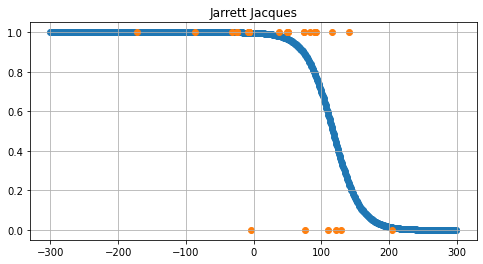

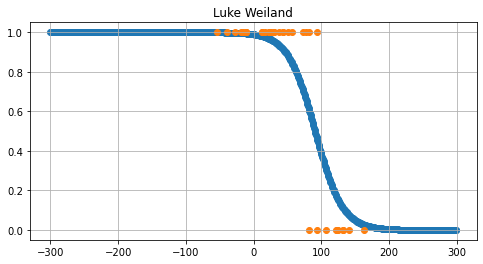

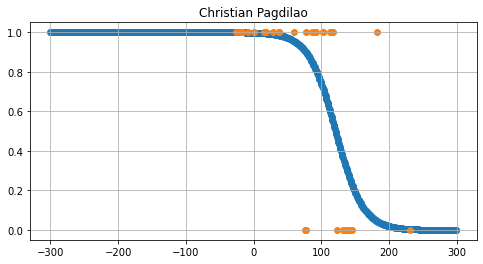

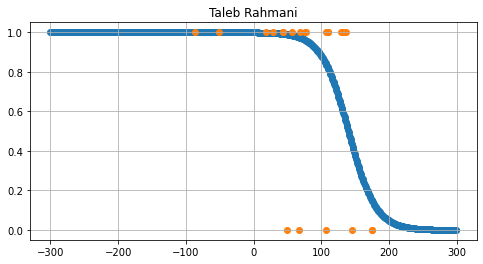

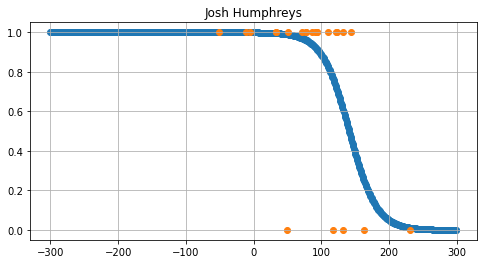

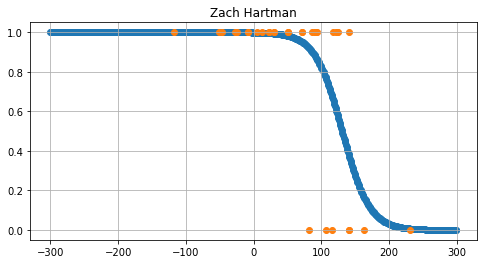

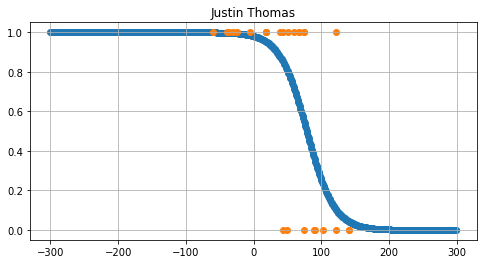

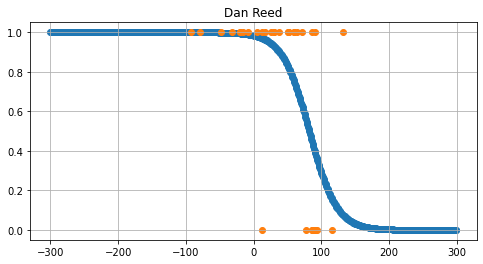

In [20]:
skill_plot('Jarrett Jacques')
skill_plot('Luke Weiland')
skill_plot('Christian Pagdilao')
skill_plot('Taleb Rahmani')
skill_plot('Josh Humphreys')
skill_plot('Zach Hartman')
skill_plot('Justin Thomas')
skill_plot('Dan Reed')



In [21]:
wrest_lookup('Jason Nolf',training_data,'all').sort_values(by = 'date')

,wrest_rank,wrest_name,wrest_win,wrest_loss,wrest_yr,wrest_school_rank,wrest_school,wrest_conf,opp_rank,opp_name,opp_win,opp_loss,opp_yr,opp_school_rank,opp_school,opp_conf,date,season,event,event_type,weight,by,loser_pts,winner_pts,time,loc,pt_diff,score_diff
89,1,Jason Nolf,31.0,0.0,SR,1.0,Penn State,Big Ten,192,Joseph Andrassy,5.0,14.0,NaN,60.0,Kent State,MAC,2018-11-11,2019,Kent State - Penn State Dual,D,157,FALL,NaN,NaN,149.0,H,NaN,5.2
88,1,Jason Nolf,31.0,0.0,SR,1.0,Penn State,Big Ten,44,Matthew Zovistoski,26.0,15.0,NaN,43.0,Appalachian State,SoCon,2018-11-18,2019,Keystone Classic,T,157,FALL,NaN,NaN,143.0,T,NaN,5.2
87,1,Jason Nolf,31.0,0.0,SR,1.0,Penn State,Big Ten,80,Evan Barczak,20.0,14.0,SO,56.0,Drexel,EIWA,2018-11-18,2019,Keystone Classic,T,157,FALL,NaN,NaN,286.0,T,NaN,5.2
86,1,Jason Nolf,31.0,0.0,SR,1.0,Penn State,Big Ten,120,Gary Dinmore,4.0,9.0,NaN,36.0,Rider,EWL,2018-11-18,2019,Keystone Classic,T,157,MD,10.0,22.0,420.0,T,12.0,12.0
85,1,Jason Nolf,31.0,0.0,SR,1.0,Penn State,Big Ten,180,Carl Antrassian,5.0,12.0,NaN,50.0,Pennsylvania,EIWA,2018-11-18,2019,Keystone Classic,T,157,FALL,NaN,NaN,135.0,T,NaN,5.2
84,1,Jason Nolf,31.0,0.0,SR,1.0,Penn State,Big Ten,18,Zach Hartman,28.0,9.0,FR,52.0,Bucknell,EIWA,2018-11-30,2019,Penn State - Bucknell Dual,D,157,FALL,NaN,NaN,229.0,A,NaN,5.2
83,1,Jason Nolf,31.0,0.0,SR,1.0,Penn State,Big Ten,9,Josh Humphreys,22.0,8.0,FR,12.0,Lehigh,EIWA,2018-12-02,2019,Lehigh - Penn State Dual,D,157,FALL,NaN,NaN,379.0,H,NaN,5.2
82,1,Jason Nolf,31.0,0.0,SR,1.0,Penn State,Big Ten,13,Christian Pagdilao,27.0,10.0,SR,21.0,Arizona State,PAC 12,2018-12-14,2019,Arizona State - Penn State Dual,D,157,MD,5.0,18.0,420.0,H,13.0,13.0
39,1,Jason Nolf,31.0,0.0,SR,1.0,Penn State,Big Ten,34,Dominick Mandarino,21.0,9.0,SO,35.0,Stanford,PAC 12,2019-01-01,2019,Southern Scuffle,T,157,FALL,NaN,NaN,322.0,T,NaN,5.2
81,1,Jason Nolf,31.0,0.0,SR,1.0,Penn State,Big Ten,104,Jared Hill,11.0,10.0,NaN,35.0,Stanford,PAC 12,2019-01-01,2019,Southern Scuffle,T,157,FALL,NaN,NaN,81.0,T,NaN,5.2
